# <h1 style="text-align: center;">Optimal Control of TCLab using a Gaussian process regression embedded in Pyomo - notebook v5b</h1>

<p style="text-align: center;">Alex Dowling<sup>a</sup>, Jacob P. Krell<sup>b</sup>, David S. Mebane<sup>b</sup>

<p style="text-align: center;"><sup>a</sup>Department of Chemical and Biomolecular Engineering, University of Notre Dame, Notre Dame, IN 46556, USA <br>
<sup>b</sup>Department of Mechanical and Aerospace Engineering, West Virginia University, Morgantown, WV, 26506-6106, USA</p>

## Method

This method in general is the same as v5 except for the smoothing function.

- *apply rolling average* to raw data as a smoothing function
- take derivative of smoothed data, which is possible via chain rule of GP analytic gradient
- fit GP to derivative, which is the "GP Model" of TCLab
- integrate GP to validate model of derivative

## Setup

In [1]:
import os
dir = os.path.abspath('')  # directory of notebook
import pandas as pd
import numpy as np
from FoKL import FoKLRoutines
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

Load and parse data:

In [2]:
filename = "tclab_sine_test.csv"
data = pd.read_csv(os.path.join(dir, filename))

tvec = data["Time"].values
Q1 = data["Q1"].values
TS1 = data["T1"].values

Define heater power control signal:

In [3]:
Q1f = interp1d(tvec, Q1, kind='previous')  # piecewise Q1
dQ1f_analytic = lambda t: 1500 * np.cos(30 * np.pi * t / tvec[-1]) * np.pi / tvec[-1]  # derivative of analytic Q1
dQ1f = interp1d(tvec, dQ1f_analytic(tvec), kind='previous')  # piecewise derivative of analytic Q1

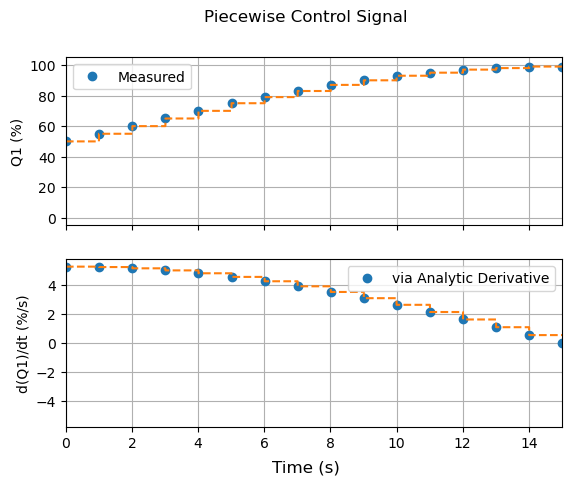

In [4]:
tvec_ub = tvec[1::] - 1e-3  # upper bounds for piecewise plots
tvec_piecewise = [tvec[0]]
for i in range(len(tvec_ub)):
    tvec_piecewise += [tvec_ub[i], tvec[i + 1]]
tvec_piecewise = np.array(tvec_piecewise)

fig, axs = plt.subplots(2, 1, sharex=True)
fig.suptitle("Piecewise Control Signal")
fig.supxlabel("Time (s)")

axs[0].plot(tvec, Q1, 'o')
axs[0].plot(tvec_piecewise, Q1f(tvec_piecewise), '--')
axs[0].set_ylabel("Q1 (%)")
axs[0].set_xlim([0, tvec[-1] / 15 / 4])
axs[0].legend(["Measured"])
axs[0].grid()

axs[1].plot(tvec, dQ1f_analytic(tvec), 'o')
axs[1].plot(tvec_piecewise, dQ1f(tvec_piecewise), '--')
axs[1].set_ylabel("d(Q1)/dt (%/s)")
axs[1].set_xlim([0, tvec[-1] / 15 / 4])
axs[1].legend(["via Analytic Derivative"])
axs[1].grid()

## Benchmark

Predicting temperatures via the two-state ODE,

In [5]:
alpha = 0.00016                                                                     # watts / (units P1 * percent U1)
P1 = 200                                                                            # P1 units
T_amb = TS1[0]  # ambient temperature

IC = [T_amb, T_amb]  # initial condition of states [TH1, TS1]
CpH =  7.006         # J/degC
CpS = 0.01           # J/degC
Ua =  0.051          # W/degC
Ub =  0.001          # W/degC

In [6]:
def dy_benchmark(t, y):
    """Benchmark ODE, for TS1."""
    TH1, TS1 = y
    dTH1 = (Ua * (T_amb - TH1) + Ub * (TS1 - TH1) + alpha * P1 * Q1f(t)) / CpH
    dTS1 = Ub * (TH1 - TS1) / CpS
    return [dTH1, dTS1]

soln_benchmark = solve_ivp(dy_benchmark, [tvec[0], tvec[-1]], IC, t_eval=tvec)

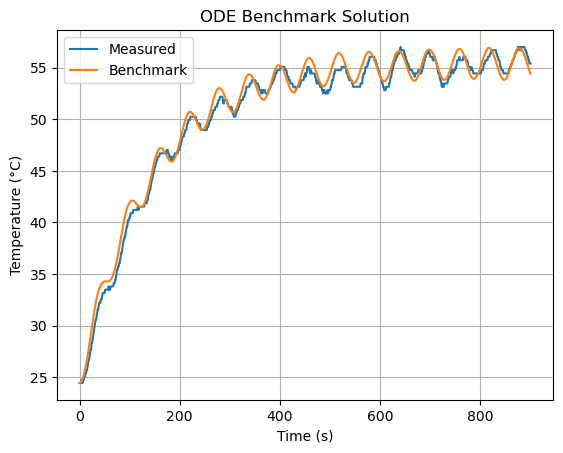

In [7]:
TS1_benchmark = soln_benchmark.y[1]

%matplotlib inline
plt.figure()
plt.plot(tvec, TS1)
plt.plot(tvec, TS1_benchmark)
plt.grid()
plt.title('ODE Benchmark Solution')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
_ = plt.legend(['Measured', 'Benchmark'])

## Derivative of Smoothed Data

Since raw measurements are noisy, a smoothing functions is applied before calculating the time derivative.

### Smoothing

Using a rolling average as the smoothing function,

In [13]:
window = 9  # odd number, mean at center +/- floor(window/2))

In [14]:
def smooth(TS1, window):
    """Apply centered average of size window."""
    TS1_smooth = np.zeros_like(TS1)
    w2 = int(np.floor(window / 2))
    w2p1 = w2 + 1

    # bleed in:
    for i in range(w2):
        TS1_smooth[i] = np.mean(TS1[:(i + w2p1)])

    # center:
    for i in range(w2, TS1_smooth.size - w2):
        TS1_smooth[i] = np.mean(TS1[(i - w2):(i + w2p1)])

    # bleed out:
    for i in range(-w2, 0):
        TS1_smooth[i] = np.mean(TS1[(i - w2)::])

    return TS1_smooth

TS1_smooth = smooth(TS1, window)

### Derivative

In [28]:
def gradient_h4(x, h):
    """h is step size. Order of error is h^4."""
    dx = np.zeros_like(x)

    # bleed in:
    h2 = 2 * h
    dx[0] = (x[1] - x[0]) / h
    dx[1] = (x[2] - x[0]) / h2

    # center difference:
    h12 = 12 * h
    for i in range(2, x.shape[0] - 2):
        dx[i] = (x[i - 2] - 8 * x[i - 1] + 8 * x[i + 1] - x[i + 2]) / h12
    
    # bleed out:
    dx[-2] = (x[-1] - x[-3]) / h2
    dx[-1] = (x[-1] - x[-2]) / h

    return dx

dTS1 = gradient_h4(TS1_smooth, tvec[1] - tvec[0])

Validating training data:

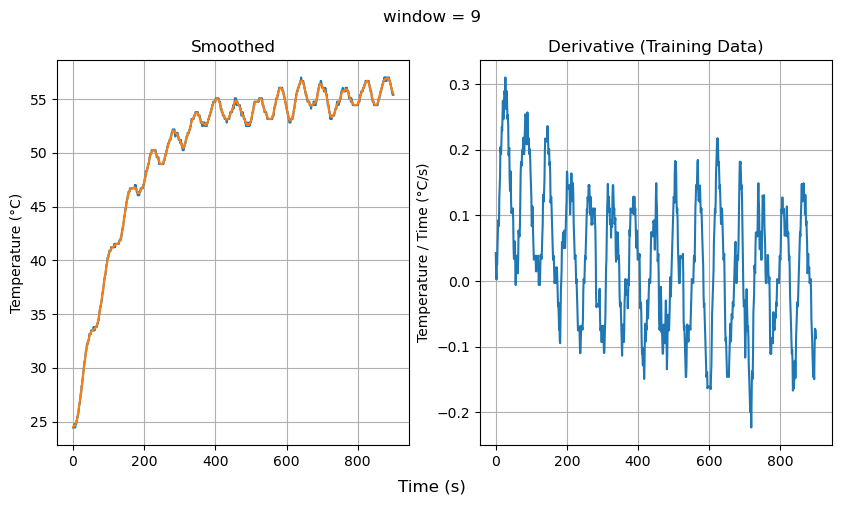

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle(f"window = {window}")
fig.supxlabel("Time (s)")

axs[0].plot(TS1)
axs[0].plot(TS1_smooth)
axs[0].set_title("Smoothed")
axs[0].set_ylabel("Temperature (°C)")
axs[0].grid()

axs[1].plot(dTS1)
axs[1].set_title("Derivative (Training Data)")
axs[1].set_ylabel("Temperature / Time (°C/s)")
axs[1].grid()

In [35]:
dTS1f = interp1d(tvec, dTS1, kind='previous')  # piecewise, grab previous value

def dy_training(t, y):
    """ODE to integrate GP's training data'."""
    return [dTS1f(t)]

soln_training = solve_ivp(dy_training, [tvec[0], tvec[-1]], [TS1_smooth[0]], t_eval=tvec)

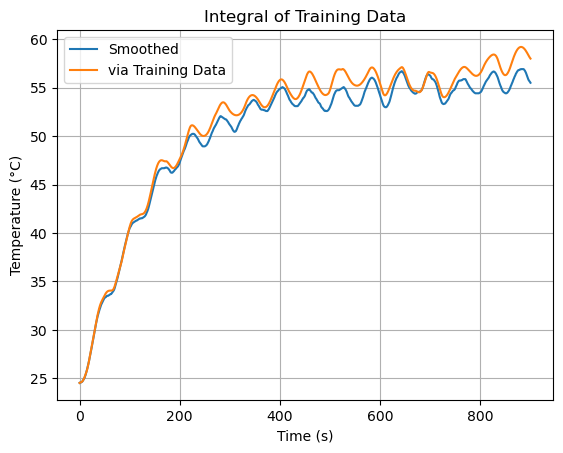

In [36]:
TS1_training = soln_training.y[0]

%matplotlib inline
plt.figure()
plt.plot(tvec, TS1_smooth)
plt.plot(tvec, TS1_training)
plt.grid()
plt.title('Integral of Training Data')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
_ = plt.legend(['Smoothed', 'via Training Data'])

## GP Model of Derivative

### Optimal Lag Time

Using lag of 15 found in v5,

In [38]:
i_opt = 15  # found in v5

GP_dT = FoKLRoutines.FoKL(kernel=1, UserWarnings=False, aic=True)
_ = GP_dT.fit([TS1[i_opt::], Q1f(tvec[:-i_opt])], dTS1[i_opt::], clean=True)  # TS1_smooth likely makes more sense

[1, -4683.434656565835]
[2, -4685.980970381287]
[2, -4709.186206917541]
[3, -4717.29345048157]
[3, -4719.8965452570765]
[4, -4719.8965452570765]
[4, -4719.8965452570765]
[4, -4721.692954266648]
[5, -4725.922757753429]
[5, -4725.760611896451]
[5, -4743.014685853222]
[6, -4743.014685853222]
[6, -4761.509140325058]
[6, -4761.509140325058]
[6, -4759.5232188989385]
[7, -4765.198308390013]
[7, -4765.433595939534]
[7, -4765.433595939534]
[7, -4765.433595939534]
[8, -4765.433595939534]


(array([[ 0.09695771,  0.21315676, -0.18296942, ...,  0.00643958,
          0.10125183,  0.14061584],
        [ 0.0985251 ,  0.21063525, -0.183691  , ...,  0.35456602,
         -0.15398189, -0.11877423],
        [ 0.10015567,  0.2058366 , -0.20857905, ...,  0.18726672,
          0.07217242, -0.40322   ],
        ...,
        [ 0.10098688,  0.21028075, -0.20247488, ...,  0.24827564,
         -0.25396782, -0.27882031],
        [ 0.09795766,  0.21291454, -0.17299633, ...,  0.2126069 ,
         -0.11177154, -0.12655075],
        [ 0.09749068,  0.20897603, -0.18432739, ...,  0.21291027,
          0.13413544, -0.09034656]]),
 array([[0., 1.],
        [1., 0.],
        [1., 1.],
        [0., 2.],
        [2., 0.],
        [2., 1.],
        [0., 3.],
        [3., 0.],
        [0., 4.],
        [4., 0.],
        [3., 2.],
        [1., 4.],
        [4., 1.],
        [5., 0.],
        [2., 4.],
        [4., 2.],
        [6., 0.],
        [3., 4.],
        [2., 5.]]),
 array([-4683.43465657, -4685

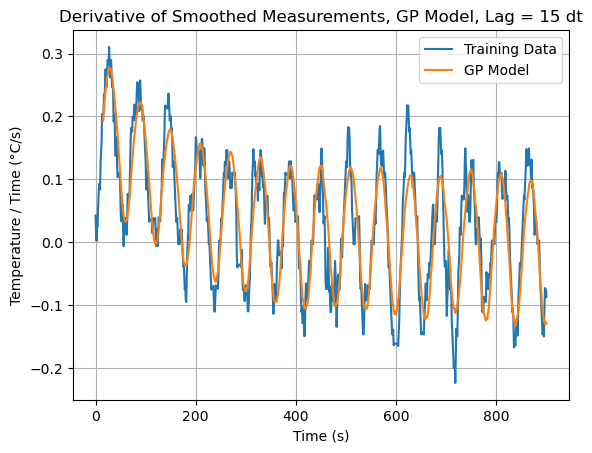

In [42]:
dTS1_GP = GP_dT.evaluate()

%matplotlib inline
plt.figure()
plt.plot(tvec, dTS1)
plt.plot(tvec[i_opt::], dTS1_GP)
plt.title(f"Derivative of Smoothed Measurements, GP Model, Lag = {i_opt} dt")
plt.xlabel('Time (s)')
plt.ylabel('Temperature / Time (°C/s)')
plt.legend(['Training Data', 'GP Model'])
plt.grid()

### Integration

In [43]:
dt = tvec[1] - tvec[0]  # assume constant time step

def dy_GP(t, y):
    """ODE to integrate GP of derivative."""
    return [GP_dT.evaluate([y[0], Q1f(t - i_opt * dt)], clean=True, SingleInstance=True)[0]]

soln_GP = solve_ivp(dy_GP, [tvec[i_opt], tvec[-1]], [TS1_smooth[i_opt]], 'LSODA', tvec[i_opt::])

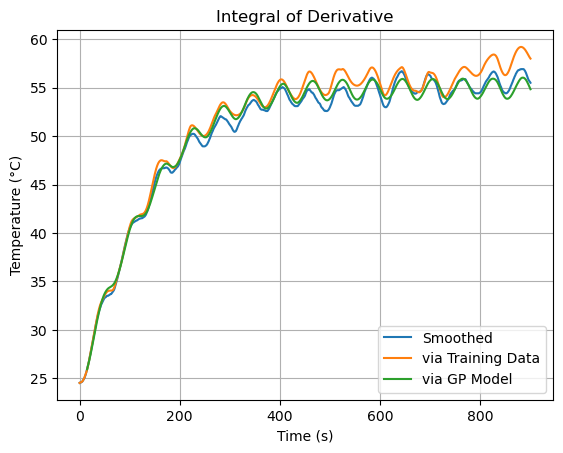

In [46]:
TS1_dGP = soln_GP.y[0]

%matplotlib inline
plt.figure()
plt.plot(tvec, TS1_smooth)
plt.plot(tvec, TS1_training)
plt.plot(tvec[i_opt::], TS1_dGP)
plt.title('Integral of Derivative')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.legend(['Smoothed', 'via Training Data', 'via GP Model'])
plt.grid()

Repeat, but with fixed time step:

In [47]:
soln_GP_fixed_dt = solve_ivp(dy_GP, [tvec[i_opt], tvec[-1]], [TS1_smooth[i_opt]], 'LSODA', tvec[i_opt::], first_step=1, min_step=1, max_step=1)

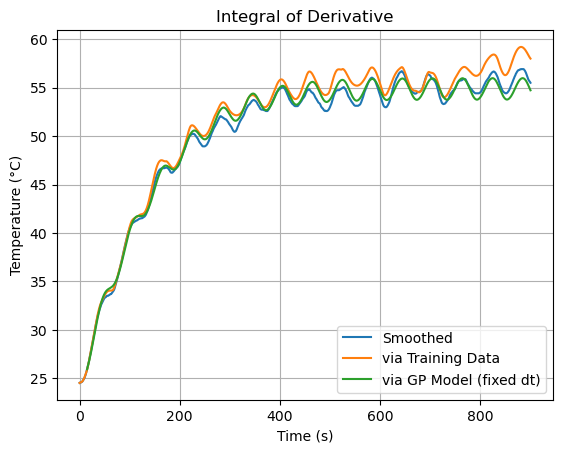

In [48]:
TS1_dGP_fixed_dt = soln_GP_fixed_dt.y[0]

%matplotlib inline
plt.figure()
plt.plot(tvec, TS1_smooth)
plt.plot(tvec, TS1_training)
plt.plot(tvec[i_opt::], TS1_dGP_fixed_dt)
plt.title('Integral of Derivative')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.legend(['Smoothed', 'via Training Data', 'via GP Model (fixed dt)'])
plt.grid()

### Comparison of Variable $\Delta t$ vs. Fixed $\Delta t$

In [49]:
def _rmse(targets, predictions):
    return np.sqrt(np.mean((predictions - targets) ** 2))

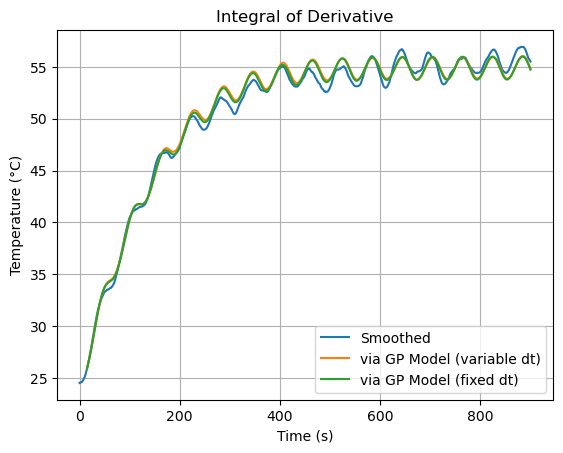

Comparison of Variable dt vs. Fixed dt:

    | Timestep | RMSE (°C) |
    |----------|-----------|
    | Variable | 0.6615504 |
    | Fixed    | 0.5862576 |


In [50]:
RMSE_dGP = _rmse(TS1_smooth[i_opt::], TS1_dGP)
RMSE_dGP_fixed_dt = _rmse(TS1_smooth[i_opt::], TS1_dGP_fixed_dt)

%matplotlib inline
plt.figure()
plt.plot(tvec, TS1_smooth)
plt.plot(tvec[i_opt::], TS1_dGP)
plt.plot(tvec[i_opt::], TS1_dGP_fixed_dt)
plt.title('Integral of Derivative')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.legend(['Smoothed', 'via GP Model (variable dt)', 'via GP Model (fixed dt)'])
plt.grid()
plt.show()

print(f"Comparison of Variable dt vs. Fixed dt:\n\n\
    | Timestep | RMSE (°C) |\n\
    |----------|-----------|\n\
    | Variable | {"{0:0.7f}".format(round(RMSE_dGP, 7))} |\n\
    | Fixed    | {"{0:0.7f}".format(round(RMSE_dGP_fixed_dt, 7))} |")

## GP Model of Residual

- targets: smoothed data
- predictions: fixed timestep

In [52]:
res = TS1_smooth[i_opt::] - TS1_dGP_fixed_dt

GP_res = FoKLRoutines.FoKL(kernel=1, UserWarnings=False, aic=True)
_ = GP_res.fit(tvec[i_opt::], res, clean=True)

[1, -261.40701655541716]
[2, -693.1132954456482]
[3, -692.3992983494875]
[4, -710.0195776929079]
[5, -731.5408511963235]
[6, -735.0807794435407]
[7, -735.0807794435407]
[8, -735.0807794435407]
[9, -986.893794736045]
[10, -986.1470391561261]
[11, -1148.839498296808]
[12, -1147.3177240194063]
[13, -1205.3200286001784]
[14, -1222.3054201728419]
[15, -1223.1363210650384]
[16, -1265.8757757473259]
[17, -1285.9752101483164]
[18, -1347.1674282357158]
[19, -1406.058085831739]
[20, -1425.380773201368]


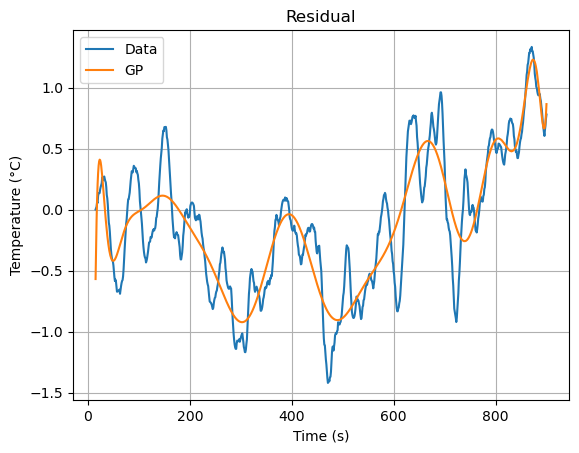

In [53]:
res_GP = GP_res.evaluate()

%matplotlib inline
plt.figure()
plt.plot(tvec[i_opt::], res)
plt.plot(tvec[i_opt::], res_GP)
plt.title('Residual')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.legend(['Data', 'GP'])
plt.grid()
plt.show()

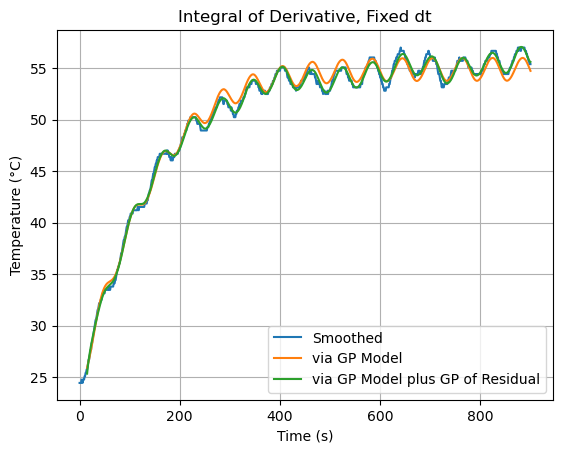

In [54]:
TS1_dGP_fixed_dt_plus_res = TS1_dGP_fixed_dt + res_GP

%matplotlib inline
plt.figure()
plt.plot(tvec, TS1)
plt.plot(tvec[i_opt::], TS1_dGP_fixed_dt)
plt.plot(tvec[i_opt::], TS1_dGP_fixed_dt_plus_res)
plt.title('Integral of Derivative, Fixed dt')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.legend(['Smoothed', 'via GP Model', 'via GP Model plus GP of Residual'])
plt.grid()
plt.show()

Repeat, but with raw data:

In [55]:
res_raw = TS1[i_opt::] - TS1_dGP_fixed_dt

GP_res_raw = FoKLRoutines.FoKL(kernel=1, UserWarnings=False, aic=True)
_ = GP_res_raw.fit(tvec[i_opt::], res_raw, clean=True)

[1, -179.17157097407107]
[2, -562.2825329052755]
[3, -561.3204303267948]
[4, -576.8065061844627]
[5, -594.7630725439644]
[6, -596.9962909557321]
[7, -596.9962909557321]
[8, -596.9962909557321]
[9, -809.6946872280528]
[10, -809.6298431103567]
[11, -939.3488800118982]
[12, -939.3488800118982]
[13, -986.5214271606951]
[14, -1005.1980519457991]
[15, -1004.7460804932762]
[16, -1045.4512380591477]
[17, -1057.9976688109004]
[18, -1100.6464124682057]
[19, -1139.8940343019276]
[20, -1153.106449412102]


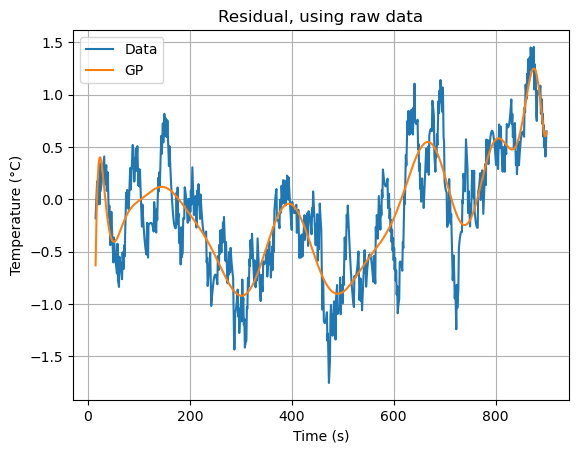

In [56]:
res_GP_raw = GP_res_raw.evaluate()

%matplotlib inline
plt.figure()
plt.plot(tvec[i_opt::], res_raw)
plt.plot(tvec[i_opt::], res_GP_raw)
plt.title('Residual, using raw data')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.legend(['Data', 'GP'])
plt.grid()
plt.show()

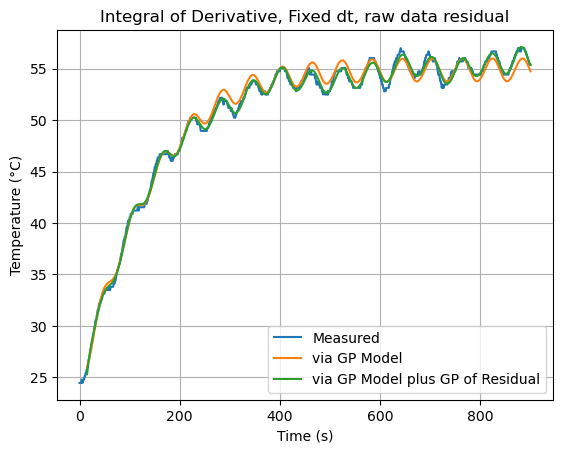

In [57]:
TS1_dGP_fixed_dt_plus_res_raw = TS1_dGP_fixed_dt + res_GP_raw

%matplotlib inline
plt.figure()
plt.plot(tvec, TS1)
plt.plot(tvec[i_opt::], TS1_dGP_fixed_dt)
plt.plot(tvec[i_opt::], TS1_dGP_fixed_dt_plus_res_raw)
plt.title('Integral of Derivative, Fixed dt, raw data residual')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.legend(['Measured', 'via GP Model', 'via GP Model plus GP of Residual'])
plt.grid()
plt.show()

## Benchmark Comparison

Since the residual, modeled only with $t$, does not seem to provide significant improvement, the integrated GP at fixed timestep will be considered the predictions.

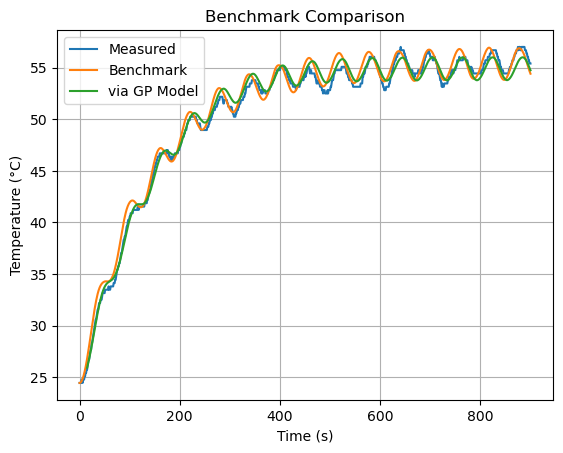

Benchmark Comparison:

    | Method                                 | RMSE (°C) |
    |----------------------------------------|-----------|
    | Benchmark (ODE)                        | 0.8116180 |
    | GP (piecewise Q1, lagged Q1, fixed dt) | 0.5862576 |


In [59]:
%matplotlib inline
plt.figure()
plt.plot(tvec, TS1)
plt.plot(tvec, TS1_benchmark)
plt.plot(tvec[i_opt::], TS1_dGP_fixed_dt)
plt.title('Benchmark Comparison')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.legend(['Measured', 'Benchmark', 'via GP Model'])
plt.grid()
plt.show()

RMSE_benchmark = _rmse(TS1, TS1_benchmark)
print(f"Benchmark Comparison:\n\n\
    | Method                                 | RMSE (°C) |\n\
    |----------------------------------------|-----------|\n\
    | Benchmark (ODE)                        | {"{0:0.7f}".format(round(RMSE_benchmark, 7))} |\n\
    | GP (piecewise Q1, lagged Q1, fixed dt) | {"{0:0.7f}".format(round(RMSE_dGP_fixed_dt, 7))} |")